In [3]:
%matplotlib inline
from preamble import *

### 2.3.7 커널 서포트 벡터 머신

#### 선형 모델과 비선형 특성

직선과 초평면은 유연하지 못하여
저차원 데이터셋에서는 선형 모델이 매우 제한적

이를 유연하게 만드는 방법:
특성끼리 곱하거나 특성을 거듭제곱하는 식으로 새로운 특성 추가

Text(0, 0.5, '특성 1')

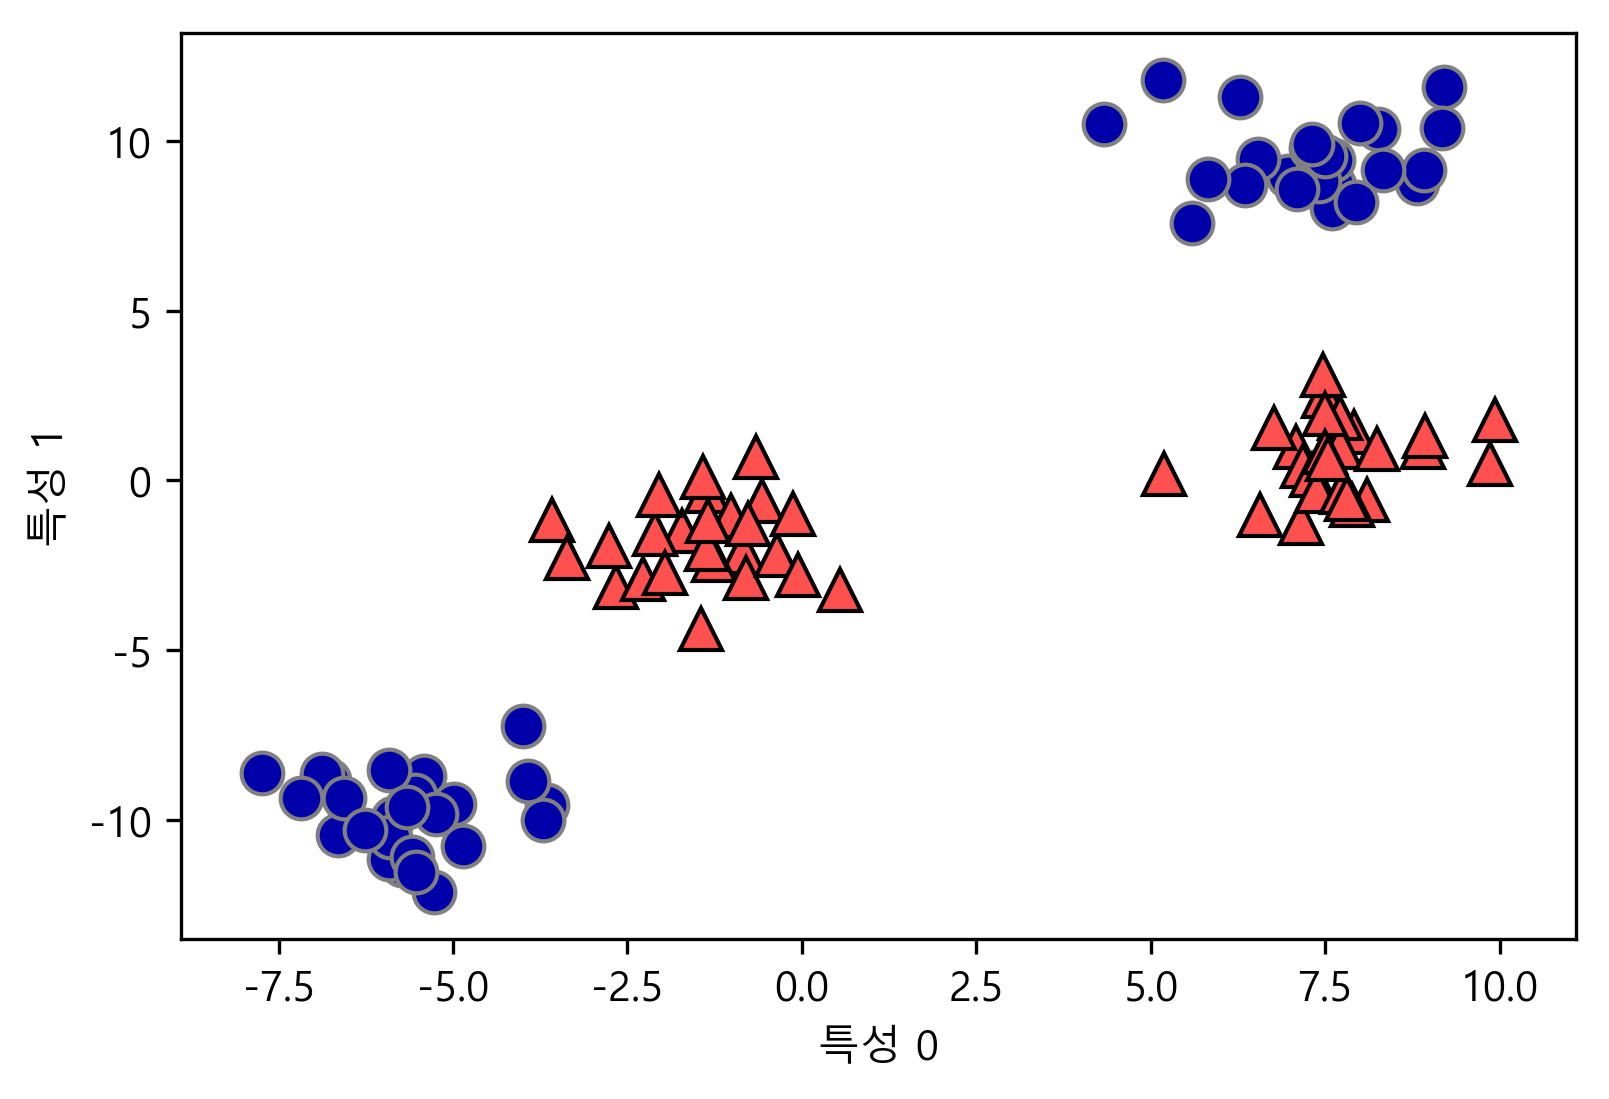

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

분류를 위한 선형 모델은 직선으로만 데이터 포인트를 나눌 수 있어서
이런 데이터셋에는 잘 들어 맞지 않음

C:\Users\jungk\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, '특성 1')

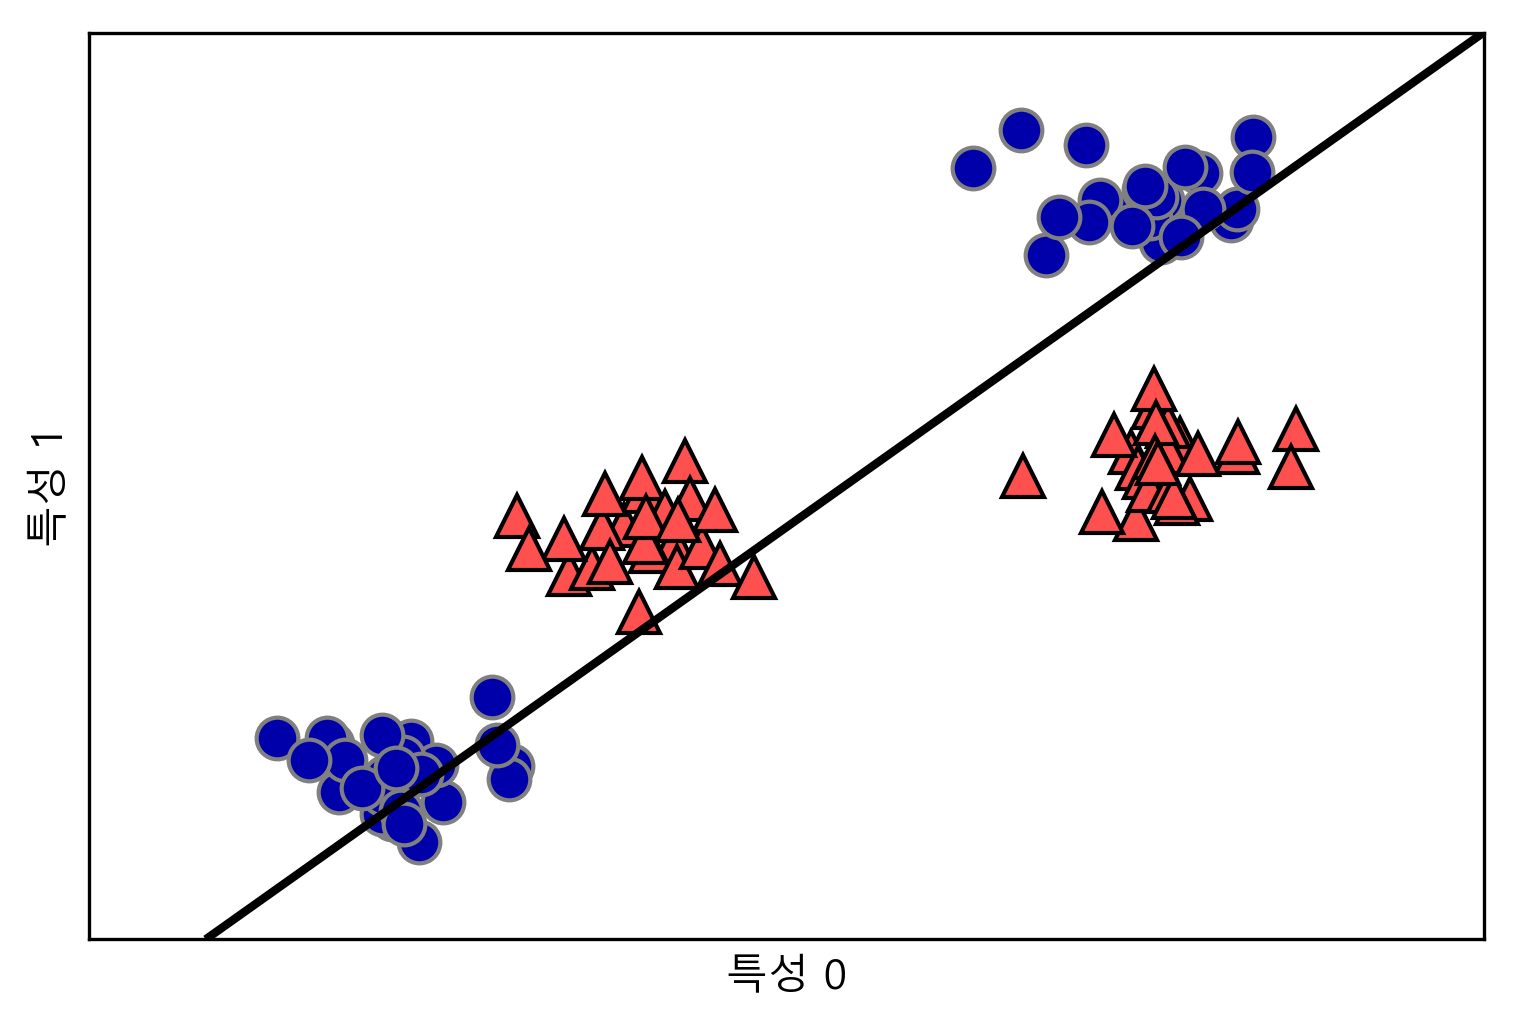

In [5]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

두 번째 특성을 제곱한 특성을 새로운 특성으로 추가해 확장

    --> 3차원 데이터

산점도 구현

Text(0.5, 0, '특성1 ** 2')

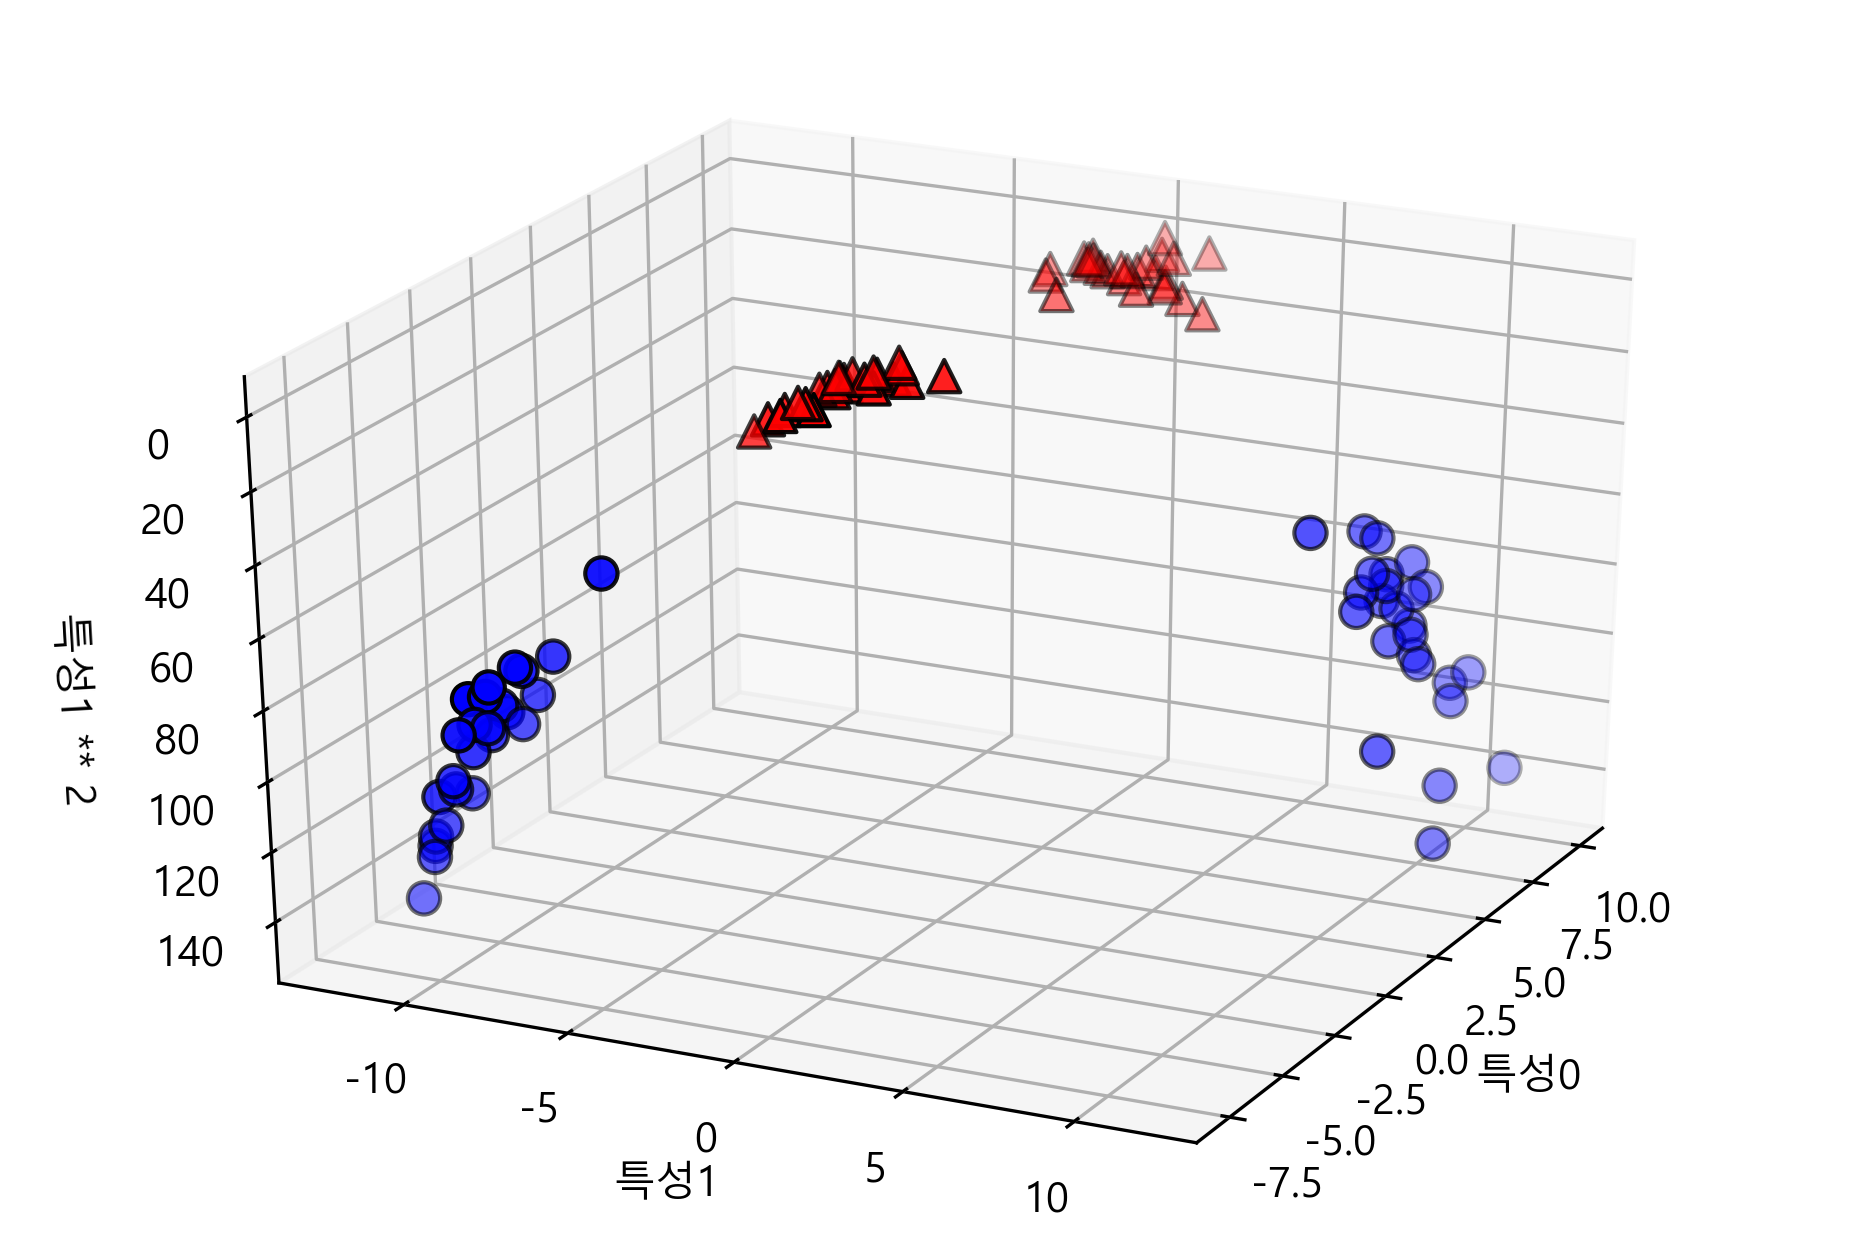

In [6]:
# 두 번째 특성을 제곱하여 추가합니다
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0 인 포인트를 먼저 그리고 그 다음 y == 1 인 포인트를 그립니다
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

새로운 데이터셋에서는 선형 모델과 3차원 공간의 평며을 사용해 구분 가능

선형모델 구현:

C:\Users\jungk\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, '특성1 ** 2')

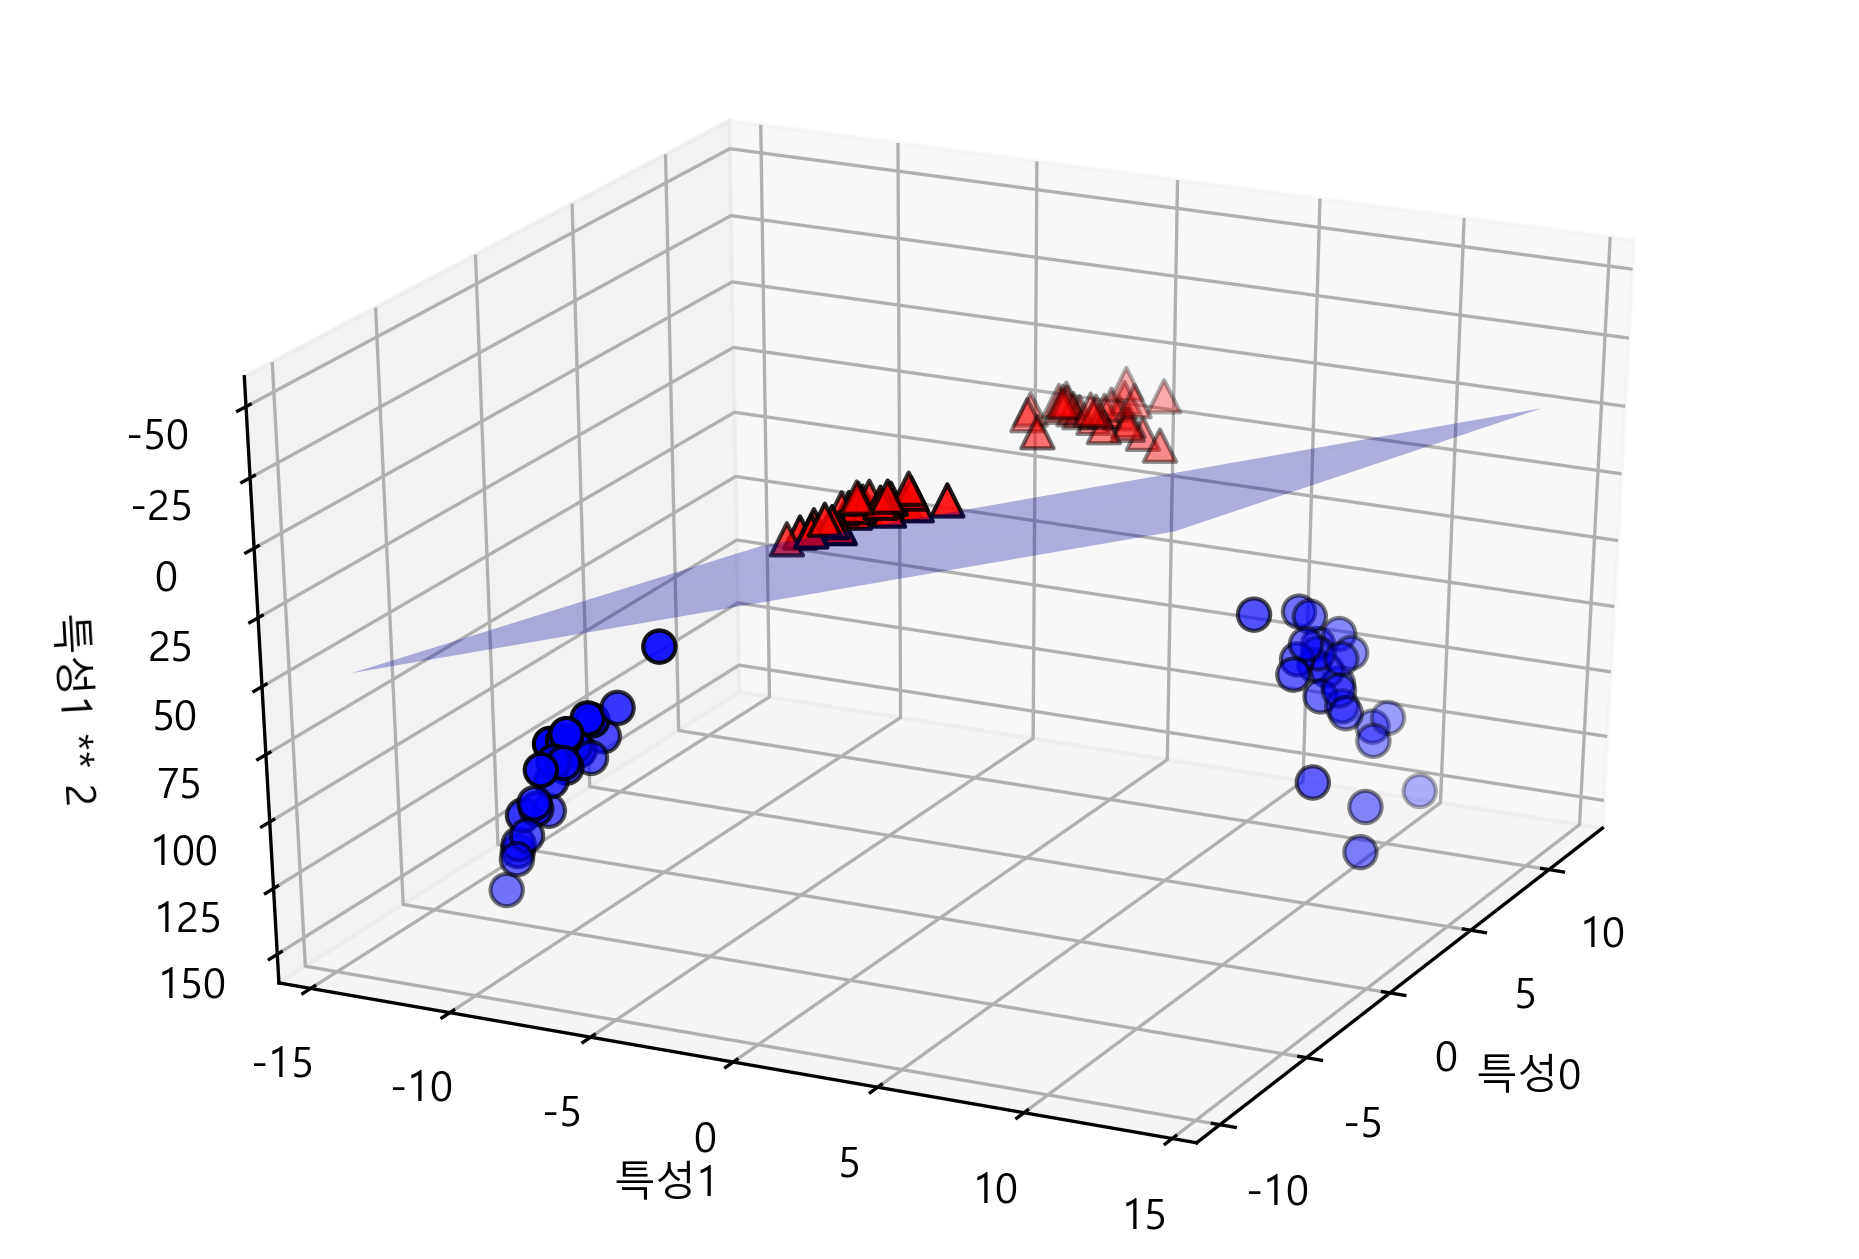

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

원래 특성으로 투영해 보면 이 선형 SVM모델은 더이상 선형이 아님
직선보다 타원에 가까운 모습

Text(0, 0.5, '특성 1')

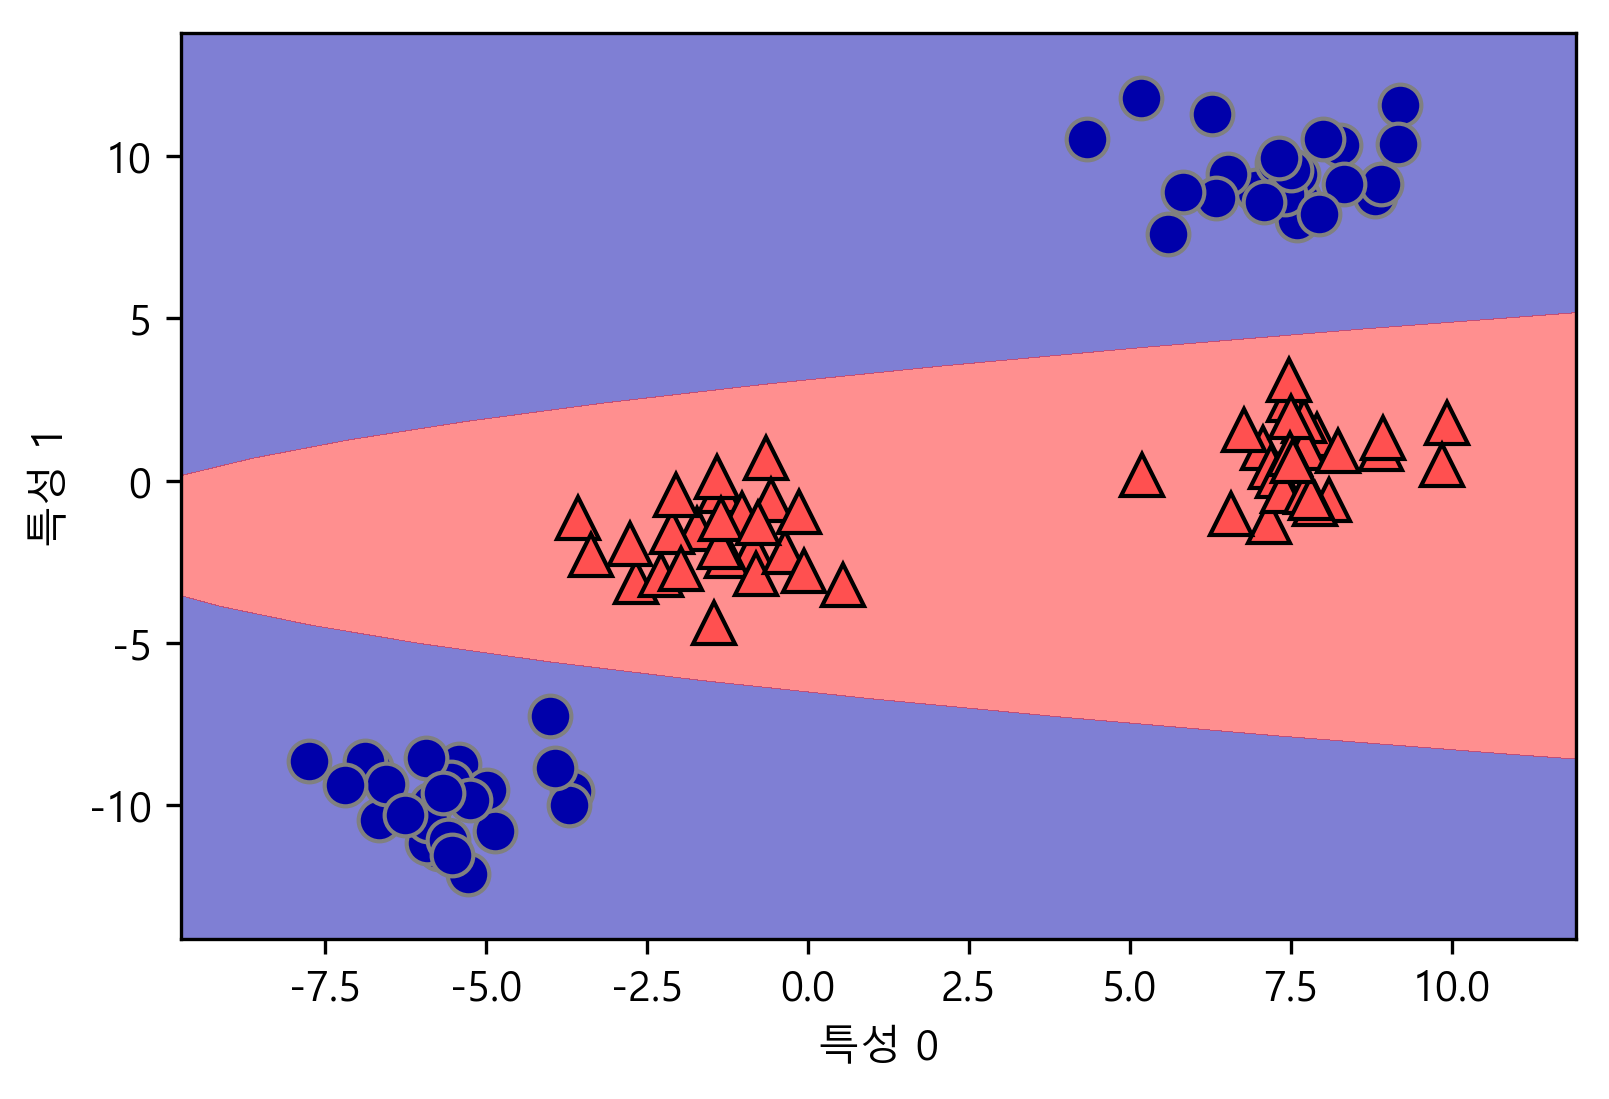

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### 커널 기법

많은 경우 어떠한 특성을 추가해야 할지 모르고,
특성을 많이 추가하면 연산비용 증가

수학적 기교를 사용해
새로운 특성을 많이 만들지 않고서도
고차원 분류길르 학습시킬 수 있음

커널 기법:

    - 실제로 데이터를 확장하지 않고
    - 확장된 특성에 대한 데이터 포인트들의 거리(스칼라곱)을 계산

데이터를 고차원 공간에 매핑하는 두 가지 주요 방법

    - 다항식 커널: 
        + 원래 특성의 가능한 조합을 지정된 차수까지 모두 계산
        
    - 가우시안 커널(RBF커널): 
        + 차원이 무한한 특성 공간에 매핑하는 것
        + 모든 차수의 모든 다항식을 고려
        + 지수 함수의 테일러 전개를 이용한 것으로
            무한한 다항식 차원으로 매핑하는 효과를 만듬
            
RBF 커널을 사용한 SVM이 결정을 만드는 방법은 비교적 쉽게 요약 가능:

#### SVM 이해하기

서포트 벡터(support vector):

    - 일반적으로 훈련 데이터의 일부만 결정 경계를 만드는 데 영향 줌
    - 바로 두 클래스 사이의 경계에 위치한 데이터 포인트들

새로운 데이터 포인트에 대해 예측

    - 각 서포트 벡터와의 거리를 측정
    - 분류 결정은 서포트 벡터까지의 거리에 기반하며
        서포트 벡터의 중요도는 훈련 과정에서 학습

데이터 포인트 사이의 거리는 가우시안 커널에 의해 계산
![Integer Memory Layout](images/fig2_334.png)

    - x_1과 x_2는 데이터 포인트
    - ||x_1 - x_2||는 유클리디안 거리
    - γ(gamma)는 가우시안 커널의 폭을 제어하는 매개변수

forge 데이터에 SVM 적용:

    - 결정 경계: 검은 실선
    - 서포트 벡터: 굵은 테두리로 크게 그림

Text(0,0.5,'특성 1')

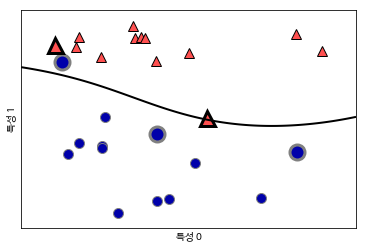

In [7]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)                                                
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

매우 부드럽고 비선형 경계 생성

여기서 사용한 두 매개변수 C와 gamma에 대해 자세히 살펴보겠습니다.

#### SVM 파라미터 튜닝

gamma(γ): 가우시안 커널 폭의 역수에 해당

    - 하나의 훈련 샘플이 미치는 영향의 범위를 결정
    - 작은 값은 넓은 영역을 의미
    - 큰 값일 경우 영향이 미치는 범위가 제한적
    다른 말로 하면, 가우시안 커널의 반경이 클수록 훈련 샘플의 영향 범위도 커집니다.
    
C: 선형 모델에서 사용한 것과 비슷한 규제 매개변수

    - 이 매개변수는 각 포인트의 중요도(정확히는 dual_coef_ 값)를 제한

이 매개변수를 다르게 했을 때 어떻게 변경되는지 살펴보겠습니다.

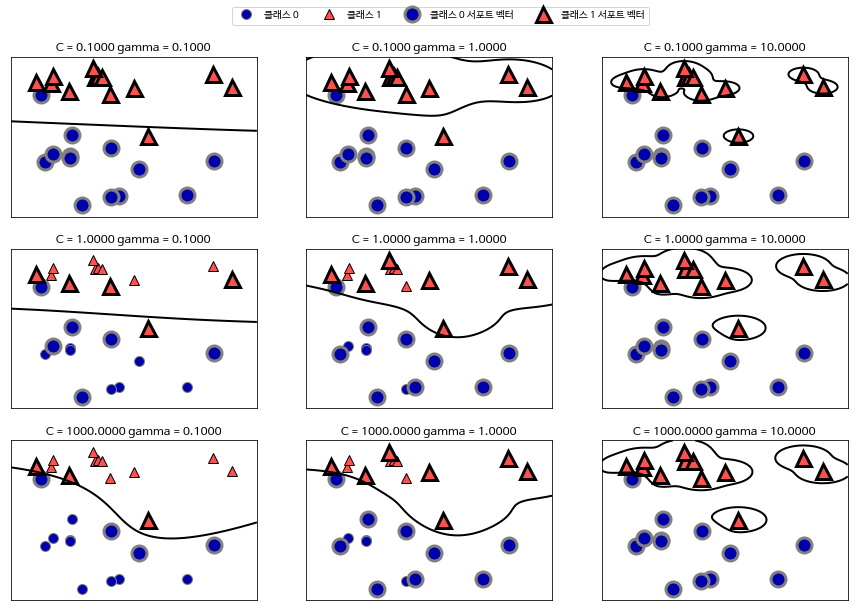

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["클래스 0", "클래스 1", "클래스 0 서포트 벡터", "클래스 1 서포트 벡터"],
                  ncol=4, loc=(.9, 1.2))

왼쪽 --> 오른쪽: γ 0.1 --> 10

    - 작은 gamma 값: 가우시안 커널의 반경을 크게
    - 많은 포인트들이 가까이 있는 것으로 고려됨
        --> 왼쪽 그림의 결정 경계는 매우 부드러움
        --> 오른쪽으로 갈수록 결정 경계는 하나의 포인트에 더 민감해짐
    - 작은 gamma 값이 결정 경계를 천천히 바뀌게 하므로 모델의 복잡도를 낮춤
    - 큰 gamma 값은 더 복잡한 모델 생성

위 --> 아래: C 0.1 --> 1000

    - 선형 모델에서처럼 작은 C는 매우 제약이 큰 모델 생성
    - 각 데이터 포인트의 영향력이 작음
        --> 왼쪽 위의 결정 경계는 거의 선형에 가까움
        --> 잘못 분류된 데이터 포인트가 경계에 거의 영향을 주지 않음
    - 왼쪽 아래 C 증가: 이 포인트들이 모델에 큰 영향을 줌
        --> 결정 경계를 휘어서 정확하게 분류하게 함

유방암 데이터셋에 적용: 디폴트값 C=1, gamma=1/n_features 사용

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_test, y_test)))

훈련 세트 정확도: 1.00
테스트 세트 정확도: 0.63


훈련 세트: 완벽, 테스트 세트 63% --> 상당한 과대적합

SVM은 잘 작동하는 편이지만 매개변수 설정과 데이터 스케일에 매우 민감

특히 입력 특성의 범위가 비슷해야 합니다.
각 특성의 최솟값과 최댓값을 로그 스케일로 나타내보겠습니다.

Text(0,0.5,'특성 크기')

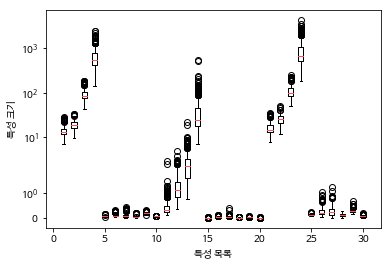

In [12]:
plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("특성 목록")
plt.ylabel("특성 크기")

그래프를 보니 유방암 데이터셋의 특성은 자릿수 자체가 완전히 다릅니다.

이것이 일부 모델(선형 모델 등)에서도 어느 정도 문제가 될 수 있지만,
커널 SVM에서는 영향이 아주 큽니다.

이 문제를 해결하는 방법을 알아보겠습니다.

#### SVM 을 위한 데이터 전처리

해결 방법 중 하나: 특성 값의 범위가 비슷해지도록 조정

커널 SVM에서는 모든 특성 값을 0과 1 사이로 맞추는 방법을 많이 사용

3장에서 MinMaxScaler 전처리 메서드 사용 처리법 다룸

여기서는 우리가 직접 만들어보겠습니다.

In [13]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면
# 각 특성에 대해 최솟값은 0 최댓값은 1 임
X_train_scaled = (X_train - min_on_training) / range_on_training
print("특성별 최솟값\n{}".format(X_train_scaled.min(axis=0)))
print("특성별 최댓값\n {}".format(X_train_scaled.max(axis=0)))

특성별 최솟값
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
특성별 최댓값
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [14]:
# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용합니다(자세한 내용은 3장에 있습니다)
X_test_scaled = (X_test - min_on_training) / range_on_training

In [15]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.948
테스트 세트 정확도: 0.951


결과가 크게 달라짐

훈련, 테스트 세트 정확도: 100%에서는 조금 멀어짐

매우 비슷해서 확실히 과소적합된 상태

여기서 C나 gamma 값을 증가시켜 좀 더 복잡한 모델을 만들 수 있음:

In [26]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.972


C 값 증가 결과: 97.2%로 향상

#### 장단점과 파라미터

장점: 

- 커널 서포트 벡터 머신은 강력한 모델이며 다양한 데이터셋에서 잘 작동
- SVM은 데이터의 특성이 몇 개 안 되더라도 복잡한 결정 경계 만듬
- 저차원과 고차원의 데이터(즉 특성이 적을 때와 많을 때)에 모두 잘 작동

단점: 
- 샘플이 많을 때는 잘 맞지 않음  
    + 10,000개의 샘플 정도면 SVM 모델이 잘 작동
    + 100,000개 이상의 데이터셋에서는 속도와 메모리 관점에서 도전적인 과제
- **데이터 전처리와 매개변수 설정**에 신경을 많이 써야 함
    --> 랜덤 포레스트나 그래디언트 부스팅 같은
        (전처리가 거의 또는 전혀 필요 없는) 트리 기반 모델을 애플리케이션에 많이 사용
- 분석하기도 어려움:
    + 어떻게 결정되었는지 이해하기 어렵고
    + 비전문가에게 모델을 설명하기가 난해

**하지만** 모든 특성이 비슷한 단위이고(예를 들면 모든 값이 픽셀의 컬러 강도)
스케일이 비슷하면 SVM을 시도해볼 만합니다.

중요한 매개변수: 

- 규제 매개변수 C, 어떤 커널을 사용할지, 각 커널에 따른 매개변수
- RBF 커널
    + 가우시안 커널 폭의 역수인 gamma 매개변수 하나

gamma와 C 모두 모델의 복잡도를 조정하며 둘 다 큰 값이 더 복잡한 모델을 만듬
그러므로 연관성이 많은 이 두 매개변수를 잘 설정하려면 C와 gamma를 함께 조정해야 함